In [ ]:
# default_exp data.tsloader_general

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import copy
import logging
import random
from collections import defaultdict
from typing import Collection, Dict, List, Optional, Tuple
from typing_extensions import Literal

import numpy as np
import pandas as pd
import torch as t
from fastcore.foundation import patch

from nixtla.data.tsdataset import TimeSeriesDataset

In [ ]:
#export
# TODO: Check if the saturday zero protection is still in place
class TimeSeriesLoader(object):
    def __init__(self,
                 ts_dataset: TimeSeriesDataset,
                 model: Literal['nbeats', 'tcn', 'esrnn', 'rnn', 'new_rnn'],
                 window_sampling_limit: int, 
                 input_size: int,
                 output_size: int,
                 idx_to_sample_freq: int,
                 batch_size: int,
                 complete_inputs: bool,
                 complete_sample: bool,
                 shuffle: bool,
                 len_sample_chunks: Optional[int] = None,
                 n_series_per_batch: Optional[int] = None,
                 verbose: bool = False) -> 'TimeSeriesLoader':
        """
        Instatiates loader for TimeSeriesDataset.
        
        Parameters
        ----------
        ts_dataset: TimeSeriesDataset
            Object of class TimeSeriesDataset.
        model: str
            Model to be used.
            One of ['nbeats', 'tcn', 'esrnn', 'rnn', 'new_rnn'].
        window_sampling_limit: int
            Max size of observations to consider, including output_size.
        input_size: int
            Size of the training sets.
        output_size: int
            Forecast horizon.
        idx_to_sample_freq: int
            Step size to construct windows.
            Ej. if idx_to_sample_freq=7, each 7 timestamps
            a window will be constructed.
        batch_size: int
            Number of samples considered in each iteration.
        complete_inputs: bool
            Whether consider only windows of length equals to input_size.
        complete_sample: bool
            Whether consider only windows with complete output_size.
        shuffle: bool
            Shuffled batch.
            If False, batch size will be ignored and
            all windows will be used when training.
        len_sample_chunks: Optional[int] = None
            Size of complete windows.
            Only used for model = 'new_rnn'!
        n_series_per_batch: Optional[int] = None
            Number of time series per batch.
        verbose: bool = False
            Whether display informative messages.
        """
        # Dataloader attributes
        self.model = model
        self.window_sampling_limit = window_sampling_limit
        self.input_size = input_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.complete_inputs = complete_inputs
        self.complete_sample = complete_sample
        self.idx_to_sample_freq = idx_to_sample_freq
        self.ts_dataset = ts_dataset
        self.t_cols = self.ts_dataset.t_cols
        if n_series_per_batch is not None:
            self.n_series_per_batch = n_series_per_batch 
        else:
            self.n_series_per_batch = min(batch_size, self.ts_dataset.n_series)
            
        if len_sample_chunks is not None:
            if len_sample_chunks < self.input_size + self.output_size:
                raise Exception(f"Insufficient len of sample chunks {len_sample_chunks}")
            self.len_sample_chunks = len_sample_chunks
        else:
            self.len_sample_chunks = input_size + output_size
        
        self.windows_per_serie = self.batch_size // self.n_series_per_batch
        self.shuffle = shuffle
        self.verbose = verbose
        
        if not shuffle and model not in ['esrnn','rnn']:
            logging.warning('Batch size will be ignored (shuffle=False). All windows constructed will be used to train.')
        
        # Dataloader protections
        assert self.batch_size % self.n_series_per_batch == 0, \
                        f'batch_size {self.batch_size} must be multiple of n_series_per_batch {self.n_series_per_batch}'
        assert self.n_series_per_batch <= self.ts_dataset.n_series, \
                        f'n_series_per_batch {n_series_per_batch} needs to be smaller than n_series {self.ts_dataset.n_series}'
        
        self.sampleable_ts_idxs = self._get_sampleable_ts_idxs()

In [ ]:
#export
@patch
def _get_sampleable_ts_idxs(self: TimeSeriesLoader) -> List[int]:
    """
    Gets indexes of sampleable time series.
    
    Returns
    -------
    List of indexes of sampleable time series.
    """
    sum_sample_mask = self.ts_dataset.ts_tensor[:, self.t_cols.index('sample_mask')].sum(axis=1)
    ts_idxs = np.argwhere(sum_sample_mask > 1).reshape(1, -1)[0].tolist()
    
    return ts_idxs

In [ ]:
#export
@patch
def _get_sampleable_windows_idxs(self: TimeSeriesLoader, 
                                 ts_windows_flatten: t.Tensor) -> List[int]:
    """
    Gets indexes of windows that fulfills conditions.
    
    Parameters
    ----------
    ts_windwos_flatten: t.Tensor
    
    Returns
    -------
    List of indexes of ts_windows_flatten that fulfills conditions.
    """
    if not self.complete_sample:
        sample_condition = t.sum(ts_windows_flatten[:, self.t_cols.index('sample_mask'), -self.output_size:], axis=1)
        available_condition = t.sum(ts_windows_flatten[:, self.t_cols.index('available_mask'), :self.input_size], axis=1)
        if self.complete_inputs:
            completely_available_condition = 1 * (available_condition == self.input_size)
            sampling_idx = t.nonzero(completely_available_condition * sample_condition > 0)
        else:
            sampling_idx = t.nonzero(available_condition * sample_condition > 0)
    else:
        sample_condition = t.sum(ts_windows_flatten[:, self.t_cols.index('sample_mask'), -self.output_size:], axis=1)
        sample_condition = (sample_condition == (self.output_size)) * 1
        sampling_idx = t.nonzero(sample_condition)

    sampling_idx = list(sampling_idx.flatten().numpy())
    assert len(sampling_idx)>0, \
        'Check the data and masks as sample_idxs are empty, check window_sampling_limit, input_size, output_size, masks'
    
    return sampling_idx

In [ ]:
#export
@patch
def _create_windows_tensor(self: TimeSeriesLoader, 
                           ts_idxs: Optional[Collection[int]] = None) -> Tuple[t.Tensor, 
                                                                               t.Tensor]:
    """
    Creates windows tensor.
    
    Parameters
    ----------
    ts_idxs: Optional[Collection[int]]
        Indexes of time series to consider.
        Default None: returns all ts.
    
    Returns
    -------
    Tuple of two elements:
        - Windows tensor of shape (windows, channels, input_size + output_size)
        - Static variables tensor of shape (windows, series, n_static)
    """
    # Default ts_idxs=ts_idxs sends all the data, otherwise filters series      
    tensor, right_padding = self.ts_dataset.get_filtered_ts_tensor(output_size=self.output_size,
                                                                   window_sampling_limit=self.window_sampling_limit,
                                                                   ts_idxs=ts_idxs)
    tensor = t.Tensor(tensor)

    padder = t.nn.ConstantPad1d(padding=(self.input_size, right_padding), value=0)
    tensor = padder(tensor)

    # Creating rolling windows and 'flattens' them
    windows = tensor.unfold(dimension=-1, size=self.input_size + self.output_size, step=self.idx_to_sample_freq)
    # n_serie, n_channel, n_time, window_size -> n_serie, n_time, n_channel, window_size
    #print(f'n_serie, n_channel, n_time, window_size = {windows.shape}')
    windows = windows.permute(0,2,1,3)
    #print(f'n_serie, n_time, n_channel, window_size = {windows.shape}')
    windows = windows.reshape(-1, self.ts_dataset.n_channels, self.input_size + self.output_size)
    
    # Broadcast s_matrix: This works because unfold in windows_tensor, orders: serie, time
    s_matrix = self.ts_dataset.s_matrix[ts_idxs]
    n_ts = self.ts_dataset.n_series if ts_idxs is None else len(ts_idxs)
    windows_per_serie = len(windows) / n_ts
    s_matrix = s_matrix.repeat(repeats=windows_per_serie, axis=0)

    return windows, s_matrix

In [ ]:
#export
@patch
def _windows_batch(self: TimeSeriesLoader, 
                   index: Collection[int]) -> Dict[str, t.Tensor]:
    """
    Creates batch based on index. Works with NBEATS, TCN models.
    
    Parameters
    ----------
    index: Collection[int]
        Indexes of time series to consider.
    
    Returns
    -------
    Dictionary with keys:
        - S
        - Y
        - X
        - available_mask
        - sample_mask
    """

    # Create windows for each sampled ts and sample random unmasked windows from each ts
    windows, s_matrix = self._create_windows_tensor(ts_idxs=index)
    sampleable_windows = self._get_sampleable_windows_idxs(ts_windows_flatten=windows)
    self.sampleable_windows = sampleable_windows

    # Get sample windows_idxs of batch
    if self.shuffle:
        windows_idxs = np.random.choice(sampleable_windows, self.batch_size, replace=True)
    else:
        windows_idxs = sampleable_windows

    # Index the windows and s_matrix tensors of batch
    windows = windows[windows_idxs]
    S = s_matrix[windows_idxs]

    # Parse windows to elements of batch
    Y = windows[:, :self.ts_dataset.n_y, :]
    X = windows[:, self.ts_dataset.n_y:self.t_cols.index('available_mask'), :]
    available_mask = windows[:, self.t_cols.index('available_mask'), :]
    sample_mask = windows[:, self.t_cols.index('sample_mask'), :]

    available_mask = available_mask.unsqueeze(1)
    available_mask = t.ones(Y.shape) * available_mask
    
    sample_mask = sample_mask.unsqueeze(1)
    sample_mask = t.ones(Y.shape) * sample_mask

    batch = {'S': S, 'Y': Y, 'X': X,
             'available_mask': available_mask,
             'sample_mask': sample_mask}
    return batch

In [ ]:
#export
@patch
def _create_windows_tensor_rnn(self: TimeSeriesLoader, 
                               ts_idxs: Optional[Collection[int]] = None) -> Tuple[t.Tensor, 
                                                                                   t.Tensor]:
    """
    Creates windows tensor for RNN models.
    
    Parameters
    ----------
    ts_idxs: Optional[Collection[int]]
        Indexes of time series to consider.
        Default None: returns all ts.
    
    Returns
    -------
    Tuple of two elements:
        - Windows tensor of shape (windows, channels, self.len_sample_chunks)
        - Static variables tensor of shape (windows, series, n_static)
    """
    # Default ts_idxs=ts_idxs sends all the data, otherwise filters series      
    tensor, right_padding = self.ts_dataset.get_filtered_ts_tensor(output_size=self.output_size,
                                                                   window_sampling_limit=self.window_sampling_limit,
                                                                   ts_idxs=ts_idxs)
    tensor = t.Tensor(tensor)

    padder = t.nn.ConstantPad1d(padding=(0, 0), value=0)
    tensor = padder(tensor)

    # Creating rolling windows and 'flattens' them
    #windows = tensor.unfold(dimension=-1, size=self.input_size + self.output_size, step=self.idx_to_sample_freq)
    windows = tensor.unfold(dimension=-1, size=self.len_sample_chunks, step=self.idx_to_sample_freq)

    # n_serie, n_channel, n_time, window_size -> n_serie, n_time, n_channel, window_size
    #print(f'n_serie, n_channel, n_time, window_size = {windows.shape}')
    windows = windows.permute(0,2,1,3)
    #print(f'n_serie, n_time, n_channel, window_size = {windows.shape}')
    windows = windows.reshape(-1, self.ts_dataset.n_channels, self.len_sample_chunks)
    
    # Broadcast s_matrix: This works because unfold in windows_tensor, orders: serie, time
    s_matrix = self.ts_dataset.s_matrix[ts_idxs]
    n_ts = self.ts_dataset.n_series if ts_idxs is None else len(ts_idxs)
    windows_per_serie = len(windows) // n_ts
    s_matrix = s_matrix.repeat(repeats=windows_per_serie, axis=0)
    idxs = ts_idxs.repeat(repeats=windows_per_serie)

    return windows, s_matrix, idxs

In [ ]:
#export
@patch
def _windows_batch_rnn(self: TimeSeriesLoader, 
                       index: Collection[int]) -> Dict[str, t.Tensor]:
    """
    Creates batch based on index. Works with RNN models.
    
    Parameters
    ----------
    index: Collection[int]
        Indexes of time series to consider.
    
    Returns
    -------
    Dictionary with keys:
        - S
        - Y
        - X
        - available_mask
        - sample_mask
        - idxs
    """
    # Create windows for each sampled ts and sample random unmasked windows from each ts
    windows, s_matrix, idxs = self._create_windows_tensor_rnn(ts_idxs=index)
    sampleable_windows = self._get_sampleable_windows_idxs(ts_windows_flatten=windows)
    self.sampleable_windows = sampleable_windows

    # Get sample windows_idxs of batch
    if self.shuffle:
        windows_idxs = np.random.choice(sampleable_windows, self.batch_size, replace=True)
    else:
        windows_idxs = np.array(sampleable_windows)

    # Index the windows and s_matrix tensors of batch
    windows = windows[windows_idxs]
    S = s_matrix[windows_idxs]
    idx = idxs[windows_idxs]

    # Parse windows to elements of batch
    Y = windows[:, self.t_cols.index('y'), :]
    X = windows[:, self.t_cols.index('y')+1:self.t_cols.index('available_mask'), :]
    available_mask = windows[:, self.t_cols.index('available_mask'), :]
    sample_mask = windows[:, self.t_cols.index('sample_mask'), :]

    batch = {'S': S, 'Y': Y, 'X': X,
             'available_mask': available_mask,
             'sample_mask': sample_mask,
             'idxs': idx}
    return batch

In [ ]:
#export
@patch
def _full_series_batch(self: TimeSeriesLoader,
                       index: Collection[int]) -> Dict[str, t.Tensor]:
    """
    Creates batch based on index. Works with RNN models.
    
    Parameters
    ----------
    index: Collection[int]
        Indexes of time series to consider.
    
    Returns
    -------
    Dictionary with keys:
        - s_matrix
        - insample_y
        - insample_x
        - idxs
    """
    #TODO: think masks, do they make sense for ESRNN and RNN??
    #TODO: padding preventivo
    ts_tensor, _ = self.ts_dataset.get_filtered_ts_tensor(output_size=self.output_size,
                                                          window_sampling_limit=self.window_sampling_limit,
                                                          ts_idxs=index)
    ts_tensor = t.Tensor(ts_tensor)

    # Trim batch to shorter time series TO AVOID ZERO PADDING, remove non sampleable ts
    # shorter time series is driven by the last ts_idx which is available
    # non-sampleable ts is driver by the first ts_idx which stops beeing sampleable
    available_mask_tensor = ts_tensor[:, self.t_cols.index('available_mask'), :]
    min_time_stamp = int(t.nonzero(t.min(available_mask_tensor, axis=0).values).min())
    sample_mask_tensor = ts_tensor[:, self.t_cols.index('sample_mask'), :]

    max_time_stamp = int(t.nonzero(t.min(sample_mask_tensor, axis=0).values).max())

    available_ts = max_time_stamp - min_time_stamp
    assert available_ts >= self.input_size + self.output_size, \
           f'Time series too short for given input size {self.input_size} and output size {self.output_size}.'

    insample_y = ts_tensor[:, self.t_cols.index('y'), :]
    insample_y = insample_y[:, min_time_stamp:max_time_stamp+1] #+1 because is not inclusive

    insample_x = ts_tensor[:, self.t_cols.index('y')+1:self.t_cols.index('available_mask'), :]
    insample_x = insample_x[:, min_time_stamp:max_time_stamp+1] #+1 because is not inclusive

    s_matrix = self.ts_dataset.s_matrix[index]

    batch = {'insample_y': insample_y, 
             'idxs': index, 
             'insample_x': insample_x, 
             's_matrix': s_matrix}

    return batch

In [ ]:
#export
@patch
def __get_item__(self: TimeSeriesLoader, 
                 index: Collection[int]) -> Dict[str, t.Tensor]:
    """
    Gets batch based on index
    
    Parameters
    ----------
    index: Collection[int]
        Indexes of time series to consider.
    
    Returns
    -------
    Batch corresponding to self.model and index.
    """
    
    if self.model in ['nbeats', 'tcn']:
        return self._windows_batch(index=index)
    elif self.model in ['esrnn','rnn']:
        return self._full_series_batch(index=index)
    elif self.model in ['new_rnn', 'mqesrnn']:
        return self._windows_batch_rnn(index=index)
    else:
        assert 1<0, f'There is no batch strategy for {self.model}'

In [ ]:
#export
@patch
def __iter__(self: TimeSeriesLoader) -> Dict[str, t.Tensor]:
    """Batch iterator."""
    n_series = len(self.sampleable_ts_idxs)
    # Shuffle idx before epoch if self._is_train
    # Hierarchical sampling
    # 1. Sampling series
    if self.shuffle:
        sample_idxs = np.random.choice(a=self.sampleable_ts_idxs, 
                                       size=n_series, 
                                       replace=False)
    else:
        sample_idxs = np.array(self.sampleable_ts_idxs)
    
    n_batches = int(np.ceil(n_series / self.n_series_per_batch)) # Must be multiple of batch_size for paralel gpu

    for idx in range(n_batches):
        ts_idxs = sample_idxs[(idx * self.n_series_per_batch) : (idx + 1) * self.n_series_per_batch]
        # 2. Sampling windows
        batch = self.__get_item__(index=ts_idxs)
        yield batch

In [ ]:
#export
@patch
def get_meta_data_col(self: TimeSeriesLoader, 
                      col: Literal['unique_id', 'last_ds']) -> List:
    """
    Gets time series metadata from TimeSeriesDataset.

    Parameters
    ----------
    col: Literal['unique_id', 'last_ds']
        Interest column.

    Returns
    -------
    List of values for each time series.
    """
    
    return self.ts_dataset.get_meta_data_col(col)

@patch
def get_n_variables(self: TimeSeriesLoader) -> Tuple[int, int]:
    """Gets number of exogenous and static variables."""
    return self.ts_dataset.n_y, self.ts_dataset.n_x, self.ts_dataset.n_s

@patch
def get_n_series(self: TimeSeriesLoader) -> int:
    """Gets number of time series."""
    return self.ts_dataset.n_series

@patch
def get_max_len(self: TimeSeriesLoader) -> int:
    """Gets max len of time series."""
    return self.ts_dataset.max_len

@patch
def get_n_channels(self: TimeSeriesLoader) -> int:
    """Gets number of channels considered."""
    return self.ts_dataset.n_channels

@patch
def get_X_cols(self: TimeSeriesLoader) -> List[str]:
    """Gets list of exogenous variables."""
    return self.ts_dataset.X_cols

@patch
def get_frequency(self: TimeSeriesLoader) -> str:
    """Gets infered frequency."""
    return self.ts_dataset.frequency

@patch
def train(self: TimeSeriesLoader) -> None:
    """Sets train mode."""
    self._is_train = True

@patch
def eval(self: TimeSeriesLoader) -> None:
    """Sets validation mode"""
    self._is_train = False

# TOY EXAMPLE RNN

In [ ]:
import numpy as np
import pandas as pd

n_weeks = 2

Y = np.concatenate([np.array(range(168*2)), 10*np.array(range(168*2))])
X1 = -np.concatenate([np.array(range(168*2)), 10*np.array(range(168*2))])
X2 = 1/(np.concatenate([np.array(range(168*2)), 10*np.array(range(168*2))])+1)

unique_id = np.array(['u1']*168*2 + ['u2']*168*2)
ds = pd.date_range(start='1/1/2018', end='1/15/2018', freq='H')[:-1].to_list() + \
     pd.date_range(start='1/1/2018', end='1/15/2018', freq='H')[:-1].to_list()

X_df = pd.DataFrame({'unique_id': unique_id, 'ds': ds, 'X1': X1, 'X2': X2})
Y_df = pd.DataFrame({'unique_id': unique_id, 'ds': ds, 'y': Y})
S_df = Y_df.drop_duplicates('unique_id')[['unique_id']].reset_index(drop=True)
S_df['s_0'] = [1,0]
S_df['s_1'] = [0,1]

In [ ]:
toy_dataset = TimeSeriesDataset(Y_df=Y_df, X_df=X_df, S_df=S_df, mask_df=None, ds_in_test=5)

In [ ]:
ts_loader = TimeSeriesLoader(ts_dataset=toy_dataset,
                             model='new_rnn',
                             #model='nbeats',
                             window_sampling_limit=toy_dataset.max_len,
                             input_size=5,
                             output_size=5,
                             idx_to_sample_freq=24,
                             batch_size=256,
                             complete_inputs=False,
                             complete_sample=False,
                             shuffle=True)

In [ ]:
dataloader = iter(ts_loader)
batch = next(dataloader)

for key, value in batch.items():
    try:
        print(f'{key}.shape', value.shape)
    except:
        print(f'error with {key}')

S.shape (256, 2)
Y.shape torch.Size([256, 10])
X.shape torch.Size([256, 2, 10])
available_mask.shape torch.Size([256, 10])
sample_mask.shape torch.Size([256, 10])
idxs.shape (256,)


In [ ]:
for key, value in batch.items():
    assert value.shape[0] == 256, f'Error in {key}'

## CHECKING NEW RNN CHUNKED INPUTS

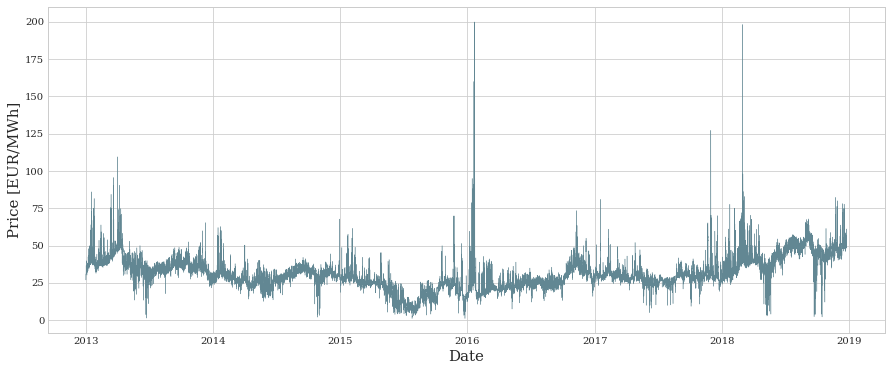

INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0.0         2016-12-27 2018-12-24 23:00:00
          1.0         2013-01-01 2016-12-26 23:00:00
INFO:root:Total data 			52416 time stamps
INFO:root:Available percentage=100.0, 	52416 time stamps
INFO:root:Insample  percentage=66.67, 	34944.0 time stamps
INFO:root:Outsample percentage=33.33, 	17472.0 time stamps
INFO:root:



In [ ]:
import pandas as pd
from nixtla.data.datasets.epf import EPF, EPFInfo

import pylab as plt
from pylab import rcParams
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'serif'

FONTSIZE = 17

# Load and plot data
Y_df, X_df, S_df = EPF.load_groups(directory='../data', groups=['NP'])

fig = plt.figure(figsize=(15, 6))
plt.plot(Y_df.ds, Y_df.y.values, color='#628793', linewidth=0.4)
plt.ylabel('Price [EUR/MWh]', fontsize=15)
plt.xlabel('Date', fontsize=15)
# plt.savefig('./results/NP.png', bbox_inches = 'tight')
plt.show()


ts_dataset = TimeSeriesDataset(Y_df=Y_df, S_df=None, X_df=X_df, ds_in_test=728*24, verbose=True)

ts_loader = TimeSeriesLoader(ts_dataset=ts_dataset,
                             model='new_rnn',
                             #model='nbeats',
                             window_sampling_limit=ts_dataset.max_len, 
                             input_size=24*7,
                             output_size=24,
                             idx_to_sample_freq=24,
                             batch_size=16,
                             complete_inputs=False,
                             len_sample_chunks=24*7*4,
                             complete_sample=False,
                             shuffle=False)

In [ ]:
dataloader = iter(ts_loader)
batch = next(dataloader)

for key, value in batch.items():
    try:
        print(f'{key}.shape', value.shape)
    except:
        print(f'error with {key}')

S.shape (1435, 0)
Y.shape torch.Size([1435, 672])
X.shape torch.Size([1435, 10, 672])
available_mask.shape torch.Size([1435, 672])
sample_mask.shape torch.Size([1435, 672])
idxs.shape (1435,)


In [ ]:
# for key, value in batch.items():
#     assert value.shape[0] == 1435, f'Error in {key}'

# TOY EXAMPLE

In [ ]:
import numpy as np
import pandas as pd

n_weeks = 2

Y = np.concatenate([np.array(range(168*2)), 10*np.array(range(168*2))])
X1 = -np.concatenate([np.array(range(168*2)), 10*np.array(range(168*2))])
X2 = 1/(np.concatenate([np.array(range(168*2)), 10*np.array(range(168*2))])+1)

unique_id = np.array(['u1']*168*2 + ['u2']*168*2)
ds = pd.date_range(start='1/1/2018', end='1/15/2018', freq='H')[:-1].to_list() + \
     pd.date_range(start='1/1/2018', end='1/15/2018', freq='H')[:-1].to_list()

X_df = pd.DataFrame({'unique_id': unique_id, 'ds': ds, 'X1': X1, 'X2': X2})
Y_df = pd.DataFrame({'unique_id': unique_id, 'ds': ds, 'y': Y})
S_df = Y_df.drop_duplicates('unique_id')[['unique_id']].reset_index(drop=True)
S_df['s_0'] = [1,0]
S_df['s_1'] = [0,1]

In [ ]:
Y_df

unique_id                  ds     y
0          u1 2018-01-01 00:00:00     0
1          u1 2018-01-01 01:00:00     1
2          u1 2018-01-01 02:00:00     2
3          u1 2018-01-01 03:00:00     3
4          u1 2018-01-01 04:00:00     4
..        ...                 ...   ...
667        u2 2018-01-14 19:00:00  3310
668        u2 2018-01-14 20:00:00  3320
669        u2 2018-01-14 21:00:00  3330
670        u2 2018-01-14 22:00:00  3340
671        u2 2018-01-14 23:00:00  3350

[672 rows x 3 columns]

In [ ]:
toy_dataset = TimeSeriesDataset(Y_df=Y_df, X_df=X_df, S_df=S_df, mask_df=None, ds_in_test=5)

In [ ]:
ts_loader = TimeSeriesLoader(ts_dataset=toy_dataset,
                             model='nbeats',
                             window_sampling_limit=toy_dataset.max_len,
                             input_size=5,
                             output_size=5,
                             idx_to_sample_freq=24,
                             batch_size=256,
                             complete_inputs=False,
                             complete_sample=False,
                             shuffle=True)

In [ ]:
dataloader = iter(ts_loader)
batch = next(dataloader)

for key, value in batch.items():
    print(f'{key}.shape', value.shape)

S.shape (256, 2)
Y.shape torch.Size([256, 10])
X.shape torch.Size([256, 2, 10])
available_mask.shape torch.Size([256, 10])
sample_mask.shape torch.Size([256, 10])


In [ ]:
batch['S']

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.

In [ ]:
batch['Y']

tensor([[2110., 2120., 2130.,  ..., 2180., 2190., 2200.],
        [  91.,   92.,   93.,  ...,   98.,   99.,  100.],
        [2350., 2360., 2370.,  ..., 2420., 2430., 2440.],
        ...,
        [ 139.,  140.,  141.,  ...,  146.,  147.,  148.],
        [2110., 2120., 2130.,  ..., 2180., 2190., 2200.],
        [ 670.,  680.,  690.,  ...,  740.,  750.,  760.]])

In [ ]:
batch['X']

tensor([[[-2.1100e+03, -2.1200e+03, -2.1300e+03,  ..., -2.1800e+03,
          -2.1900e+03, -2.2000e+03],
         [ 4.7371e-04,  4.7148e-04,  4.6926e-04,  ...,  4.5851e-04,
           4.5641e-04,  4.5434e-04]],

        [[-9.1000e+01, -9.2000e+01, -9.3000e+01,  ..., -9.8000e+01,
          -9.9000e+01, -1.0000e+02],
         [ 1.0870e-02,  1.0753e-02,  1.0638e-02,  ...,  1.0101e-02,
           1.0000e-02,  9.9010e-03]],

        [[-2.3500e+03, -2.3600e+03, -2.3700e+03,  ..., -2.4200e+03,
          -2.4300e+03, -2.4400e+03],
         [ 4.2535e-04,  4.2355e-04,  4.2176e-04,  ...,  4.1305e-04,
           4.1135e-04,  4.0967e-04]],

        ...,

        [[-1.3900e+02, -1.4000e+02, -1.4100e+02,  ..., -1.4600e+02,
          -1.4700e+02, -1.4800e+02],
         [ 7.1429e-03,  7.0922e-03,  7.0423e-03,  ...,  6.8027e-03,
           6.7568e-03,  6.7114e-03]],

        [[-2.1100e+03, -2.1200e+03, -2.1300e+03,  ..., -2.1800e+03,
          -2.1900e+03, -2.2000e+03],
         [ 4.7371e-04,  4.7148e-0